# Check dir ( no need to care )

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# install lib needed 

In [2]:
# Pip install method (recommended)
!pip -q install ultralytics==8.3.33 opencv-python scikit-learn
import ultralytics
ultralytics.checks()

Ultralytics 8.3.33 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6519.5/8062.4 GB disk)


# Include lib needed 

In [3]:
import os, math, random, itertools, json, gc
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix, classification_report


from torchvision.models import resnet18, ResNet18_Weights

# Check device and set seed to every run give exactly result

In [4]:
SEED = 123
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


# Data preprocessing




In [5]:
DATA_DIR = "/kaggle/input/fruit-ripeness-unripe-ripe-and-rotten/fruit_ripeness_dataset/archive (1)/dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

assert os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR), "DATA_DIR must contain train/ and test/"

IM_TRAIN = 128
IM_TEST  = 128
normalize = T.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
tf_train = T.Compose([
    T.RandomResizedCrop(IM_TRAIN, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    T.TrivialAugmentWide(num_magnitude_bins=31),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
    T.RandomErasing(p=0.25)   # robustness
])
tf_test  = T.Compose([T.Resize((IM_TEST, IM_TEST)), T.ToTensor(), normalize])

ds_train = ImageFolder(TRAIN_DIR, transform=lambda x: tf_train(x.convert("RGB")))
ds_test  = ImageFolder(TEST_DIR,  transform=lambda x: tf_test(x.convert("RGB")))
classes  = ds_train.classes
num_classes = len(classes)
print(f"{num_classes} classes:", classes[:5], "...")

BATCH = 128
NW = 2
dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True, num_workers=NW, pin_memory=True, drop_last=True)
dl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, num_workers=NW, pin_memory=True)


9 classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana'] ...


# Helper function for object detection 

In [6]:

softmax = nn.Softmax(dim=1)
def topk_from_logits(logits, k=5):
    probs = softmax(logits)
    top_p, top_i = probs.topk(k, dim=1)
    return top_i, top_p

def per_class_acc(cm):
    tot = cm.sum(axis=1, keepdims=True)
    return (np.diag(cm) / np.maximum(tot.squeeze(), 1))

def show_cm_and_bars(cm, title_prefix, classes):
    cmn = cm.astype(float) / (cm.sum(axis=1, keepdims=True)+1e-9)
    plt.figure(figsize=(8,7))
    plt.imshow(cmn, interpolation="nearest")
    plt.title(f"{title_prefix} - Confusion Matrix (row-norm)")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(range(len(classes)), classes)
    plt.tight_layout()
    plt.show()

    accs = per_class_acc(cm)
    plt.figure(figsize=(10,4))
    plt.bar(range(len(classes)), accs)
    plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Per-class Accuracy")
    plt.tight_layout()
    plt.show()

def grabcut_pseudobox(img_bgr):
    h, w = img_bgr.shape[:2]
    rect = (int(w*0.1), int(h*0.1), int(w*0.8), int(h*0.8))
    mask = np.zeros((h,w), np.uint8)
    bg, fg = np.zeros((1,65), np.float64), np.zeros((1,65), np.float64)
    try:
        cv.grabCut(img_bgr, mask, rect, bg, fg, 5, cv.GC_INIT_WITH_RECT)
        mask2 = np.where((mask==cv.GC_FGD)|(mask==cv.GC_PR_FGD),1,0).astype('uint8')
        cnts,_ = cv.findContours(mask2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if not cnts: return (0,0,w,h)
        c = max(cnts, key=cv.contourArea)
        x,y,bw,bh = cv.boundingRect(c)
        pad = 0.02
        x0 = max(0, int(x - pad*w)); y0 = max(0, int(y - pad*h))
        x1 = min(w, int(x + bw + pad*w)); y1 = min(h, int(y + bh + pad*h))
        return (x0, y0, x1-x0, y1-y0)
    except Exception:
        return (0,0,w,h)

def before_after_grid(img_paths, predict_fn, title, n=5):
    n = min(n, len(img_paths))
    picks = random.sample(img_paths, n)
    plt.figure(figsize=(14, 3.2*n))
    for i, p in enumerate(picks):
        im = cv.imread(p); im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        ax1 = plt.subplot(n, 2, 2*i+1)
        ax1.imshow(im_rgb); ax1.set_title("Before"); ax1.axis("off")

        pred_name, conf = predict_fn(p)  
        after = im.copy()
        x,y,w,h = grabcut_pseudobox(after)
        cv.rectangle(after, (x,y), (x+w,y+h), (0,255,0), 2)
        cv.putText(after, f"{pred_name} {conf*100:.1f}%", (x, max(25,y-10)),
                   cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
        ax2 = plt.subplot(n, 2, 2*i+2)
        ax2.imshow(cv.cvtColor(after, cv.COLOR_BGR2RGB))
        ax2.set_title("After"); ax2.axis("off")
    plt.suptitle(title, y=1.0, fontsize=12)
    plt.tight_layout(); plt.show()


# WE compare between 3 model , lenet 5 vs renet 18 and yolo v8 

## Lenet 5

In [7]:

class LeNetSmall(nn.Module):
    def __init__(self, ncls):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5), nn.ReLU(inplace=True), nn.AvgPool2d(2),  # 128->124->62
            nn.Conv2d(6,16, 5), nn.ReLU(inplace=True), nn.AvgPool2d(2),  # 62->58->29
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*29*29, 120), nn.ReLU(True),
            nn.Linear(120, 84), nn.ReLU(True),
            nn.Linear(84, ncls)
        )
    def forward(self, x): return self.classifier(self.features(x))

def train_eval_lenet(epochs=6, lr=1e-2):
    model = LeNetSmall(num_classes).to(device)
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    crit = nn.CrossEntropyLoss(label_smoothing=0.05)
    scaler = torch.amp.GradScaler("cuda", enabled=(device=="cuda"))

    for ep in range(1, epochs+1):
        model.train(); tr_loss=0; n=0
        for xb, yb in dl_train:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(device=="cuda")):
                logits = model(xb)
                loss = crit(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tr_loss += loss.item()*xb.size(0); n += xb.size(0)
        print(f"[LeNet] Epoch {ep}/{epochs} train_loss {tr_loss/n:.3f}")

    # Evaluate
    model.eval()
    preds, probs, gts = [], [], []
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=(device=="cuda")):
        for xb, yb in dl_test:
            xb = xb.to(device)
            logits = model(xb)
            p = softmax(logits)
            pred = p.argmax(1).cpu().numpy()
            preds.extend(pred.tolist()); probs.extend(p.max(1).values.cpu().numpy().tolist())
            gts.extend(yb.numpy().tolist())
    preds = np.array(preds); gts = np.array(gts)
    cm = confusion_matrix(gts, preds, labels=list(range(num_classes)))
    top1 = (preds == gts).mean()
    # top5 (manual)
    top5_hits = []
    with torch.no_grad():
        for xb, yb in dl_test:
            xb = xb.to(device)
            logits = model(xb)
            top_i, _ = topk_from_logits(logits, k=min(5, num_classes))
            top5_hits.extend([(yy.item() in ti.cpu().numpy()) for yy, ti in zip(yb, top_i)])
    top5 = np.mean(top5_hits)

    print(f"\n[LeNet] Top-1: {top1*100:.2f}% | Top-5: {top5*100:.2f}%")
    print("\n[LeNet] Classification report:\n")
    print(classification_report(gts, preds, target_names=classes, digits=3))
    show_cm_and_bars(cm, "LeNet", classes)

    # Before/After (5 random)
    test_paths = [p for p,_ in ds_test.samples]
    def predict_lenet(path):
        x = tf_test(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            pr = softmax(model(x))[0].cpu().numpy()
        j = int(pr.argmax()); return classes[j], float(pr[j])
    before_after_grid(test_paths, predict_lenet, "LeNet: 5 random 'before/after'", n=5)
    return {"top1": top1, "top5": top5}


[LeNet] Epoch 1/6 train_loss 1.756
[LeNet] Epoch 2/6 train_loss 1.363
[LeNet] Epoch 3/6 train_loss 1.278
[LeNet] Epoch 4/6 train_loss 1.206
[LeNet] Epoch 5/6 train_loss 1.150
[LeNet] Epoch 6/6 train_loss 1.109

[LeNet] Top-1: 77.03% | Top-5: 99.52%

[LeNet] Classification report:

               precision    recall  f1-score   support

  freshapples      0.801     0.856     0.827       395
  freshbanana      0.943     0.953     0.948       381
 freshoranges      0.865     0.856     0.860       388
 rottenapples      0.787     0.862     0.823       601
 rottenbanana      0.907     0.972     0.938       530
rottenoranges      0.822     0.732     0.774       403
 unripe apple      0.625     0.437     0.514       371
unripe banana      0.487     0.802     0.606       400
unripe orange      0.800     0.133     0.229       270

     accuracy                          0.770      3739
    macro avg      0.782     0.734     0.724      3739
 weighted avg      0.786     0.770     0.754      3739



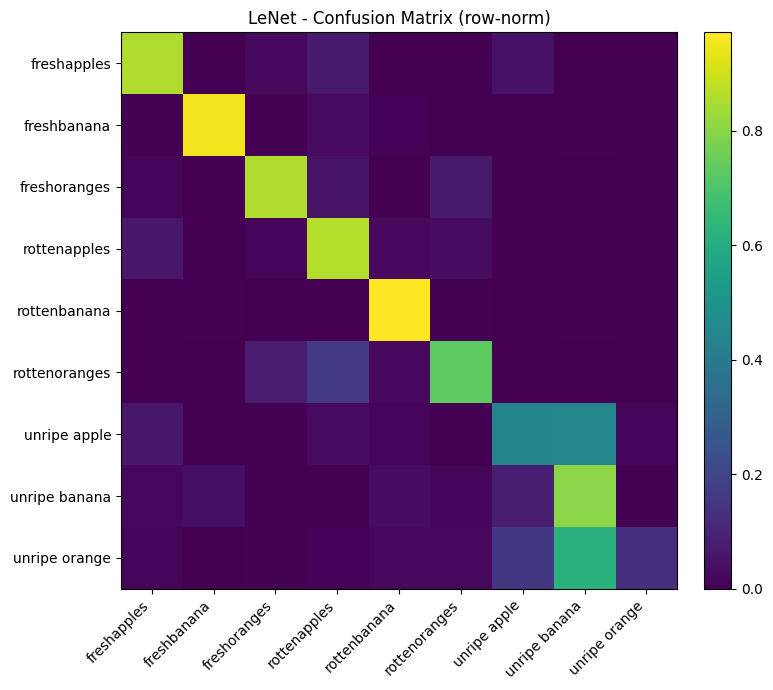

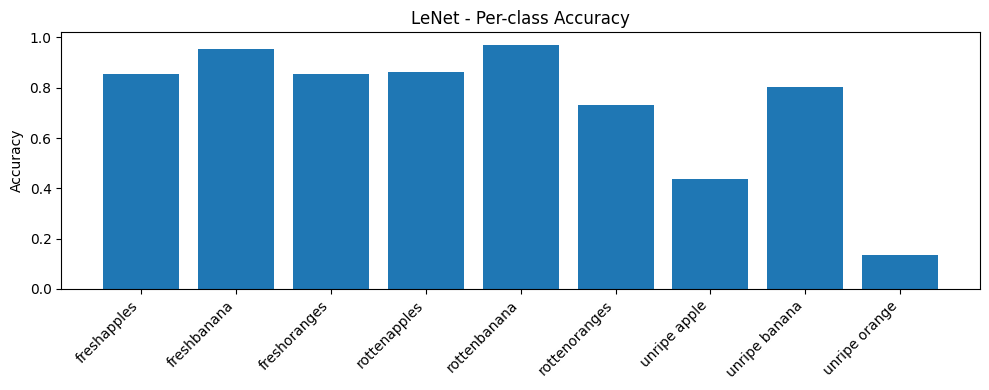

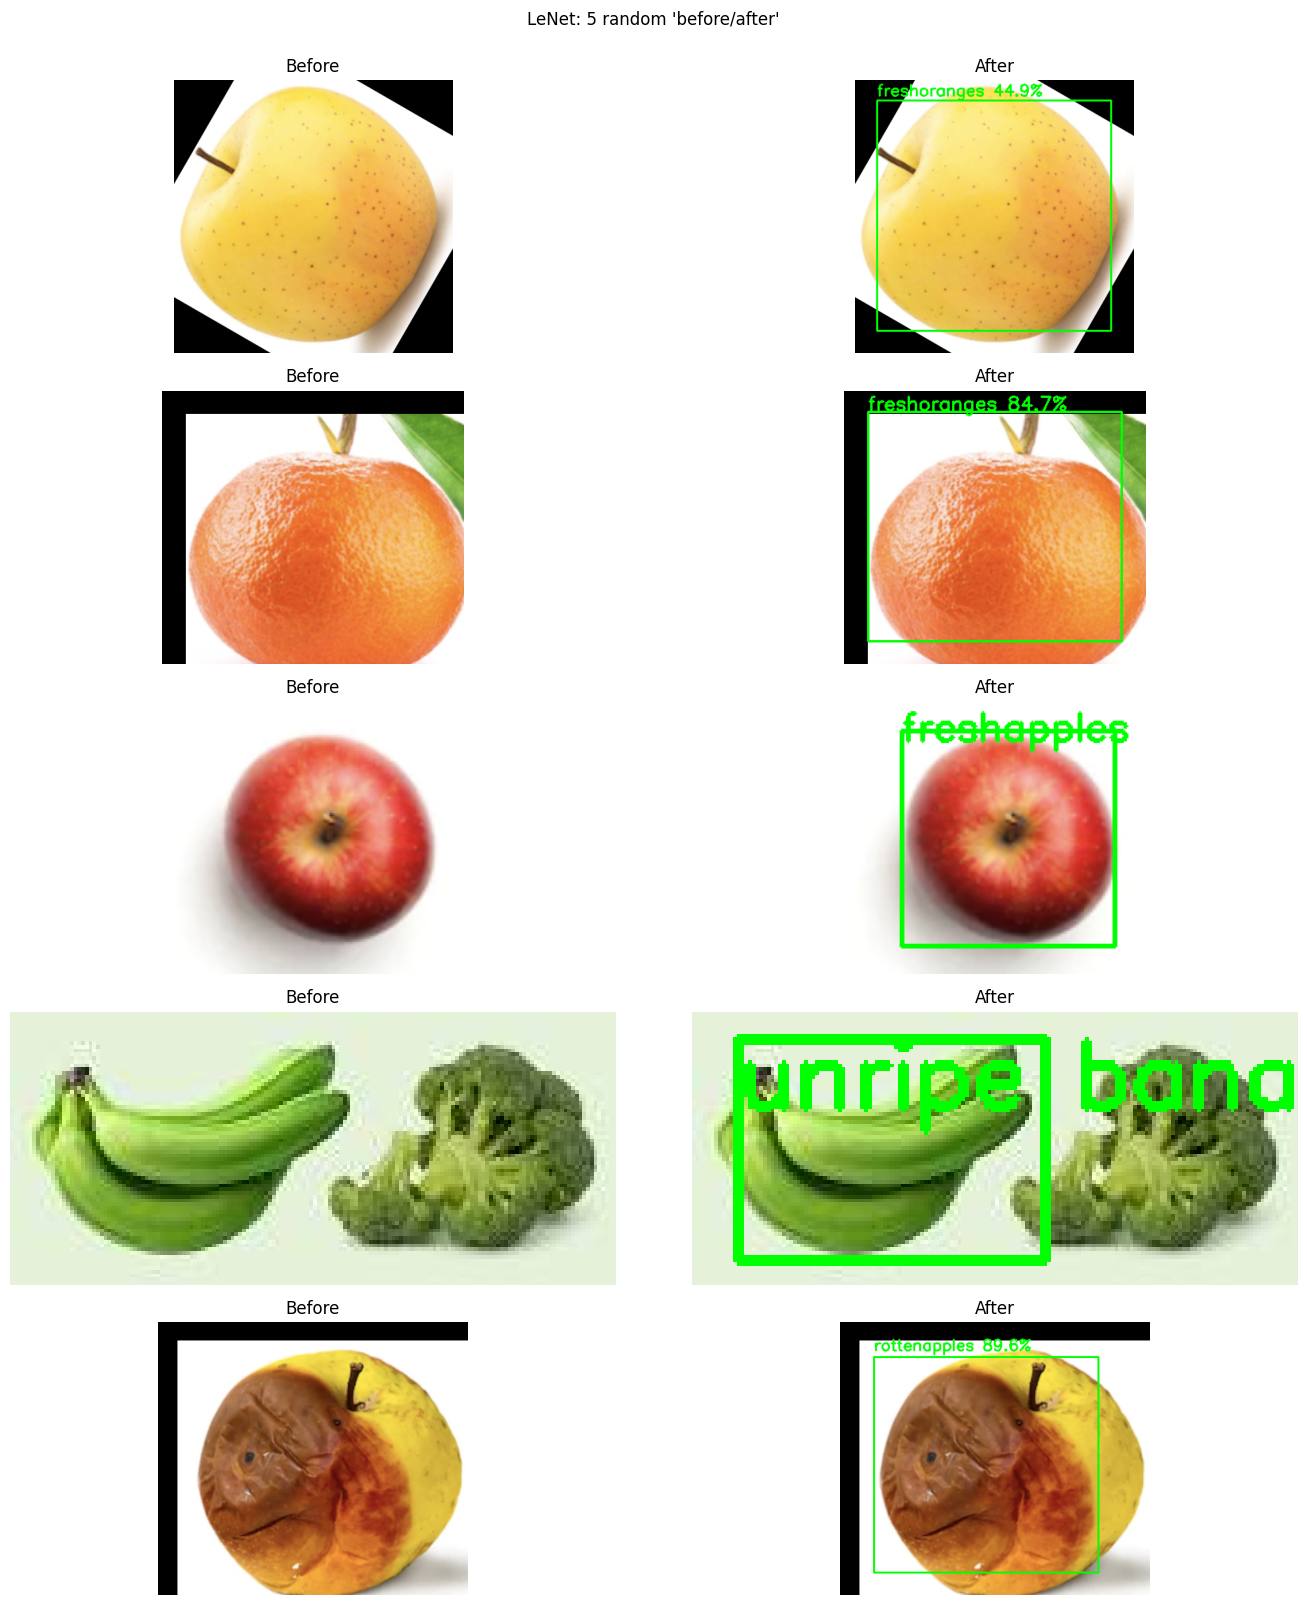

In [8]:
res_lenet   = train_eval_lenet(epochs=6,  lr=1e-2)


## Resnet 18 pretrain
in the app/web we will deploy this it have a high accuracy and also is light weight than yolo 

In [9]:

def train_eval_resnet18(epochs=10, base_lr=1e-2):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    opt = torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4, nesterov=True)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=3*base_lr, epochs=epochs, steps_per_epoch=len(dl_train))
    crit = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = torch.amp.GradScaler("cuda", enabled=(device=="cuda"))

    for ep in range(1, epochs+1):
        model.train(); tr_loss=0; n=0
        for xb, yb in dl_train:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(device=="cuda")):
                logits = model(xb); loss = crit(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            sched.step()
            tr_loss += loss.item()*xb.size(0); n += xb.size(0)
        print(f"[ResNet18] Epoch {ep}/{epochs} train_loss {tr_loss/n:.3f}")

    # Evaluate
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for xb, yb in dl_test:
            xb = xb.to(device)
            logits = model(xb)
            preds.extend(logits.argmax(1).cpu().numpy().tolist())
            gts.extend(yb.numpy().tolist())
    preds = np.array(preds); gts = np.array(gts)
    cm = confusion_matrix(gts, preds, labels=list(range(num_classes)))
    top1 = (preds == gts).mean()
    # top5
    top5_hits = []
    with torch.no_grad():
        for xb, yb in dl_test:
            xb = xb.to(device)
            logits = model(xb)
            top_i, _ = topk_from_logits(logits, k=min(5, num_classes))
            top5_hits.extend([(yy.item() in ti.cpu().numpy()) for yy, ti in zip(yb, top_i)])
    top5 = np.mean(top5_hits)

    print(f"\n[ResNet18] Top-1: {top1*100:.2f}% | Top-5: {top5*100:.2f}%")
    print("\n[ResNet18] Classification report:\n")
    print(classification_report(gts, preds, target_names=classes, digits=3))
    show_cm_and_bars(cm, "ResNet-18", classes)

    # Before/After (5 random)
    test_paths = [p for p,_ in ds_test.samples]
    def predict_resnet(path):
        x = tf_test(Image.open(path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            pr = softmax(model(x))[0].cpu().numpy()
        j = int(pr.argmax()); return classes[j], float(pr[j])
    before_after_grid(test_paths, predict_resnet, "ResNet-18: 5 random 'before/after'", n=5)
    return {"top1": top1, "top5": top5}


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s] 


[ResNet18] Epoch 1/10 train_loss 1.037
[ResNet18] Epoch 2/10 train_loss 0.712
[ResNet18] Epoch 3/10 train_loss 0.668
[ResNet18] Epoch 4/10 train_loss 0.638
[ResNet18] Epoch 5/10 train_loss 0.615
[ResNet18] Epoch 6/10 train_loss 0.589
[ResNet18] Epoch 7/10 train_loss 0.577
[ResNet18] Epoch 8/10 train_loss 0.565
[ResNet18] Epoch 9/10 train_loss 0.550
[ResNet18] Epoch 10/10 train_loss 0.542

[ResNet18] Top-1: 99.41% | Top-5: 99.95%

[ResNet18] Classification report:

               precision    recall  f1-score   support

  freshapples      0.992     1.000     0.996       395
  freshbanana      0.992     1.000     0.996       381
 freshoranges      0.995     0.997     0.996       388
 rottenapples      1.000     1.000     1.000       601
 rottenbanana      1.000     1.000     1.000       530
rottenoranges      1.000     1.000     1.000       403
 unripe apple      0.997     0.965     0.981       371
unripe banana      0.985     0.995     0.990       400
unripe orange      0.974     0.978 

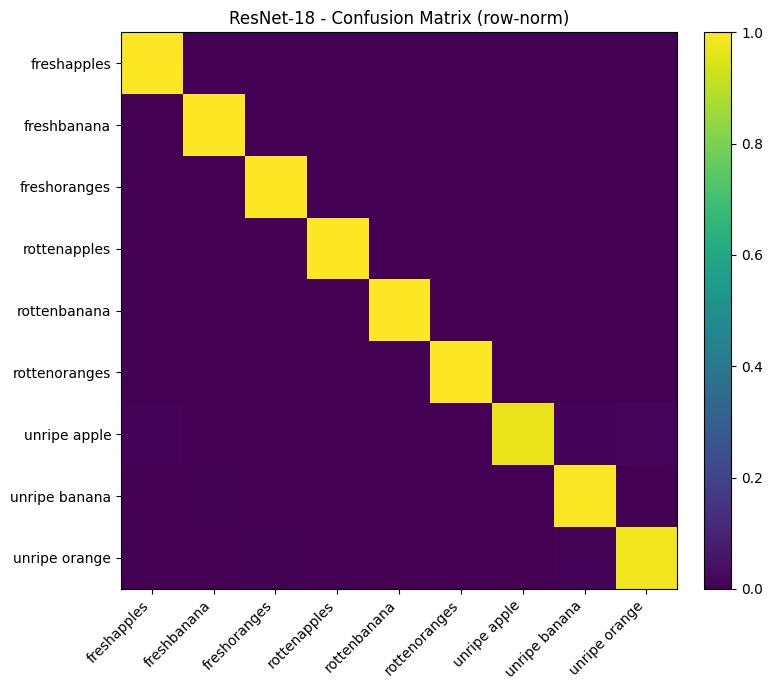

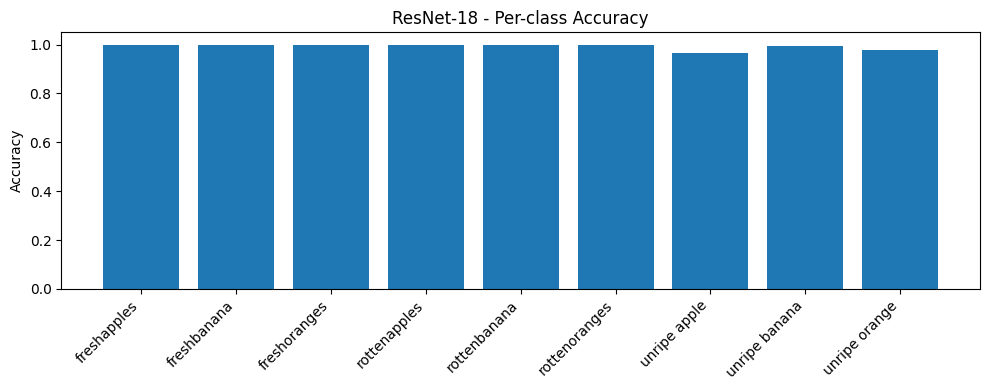

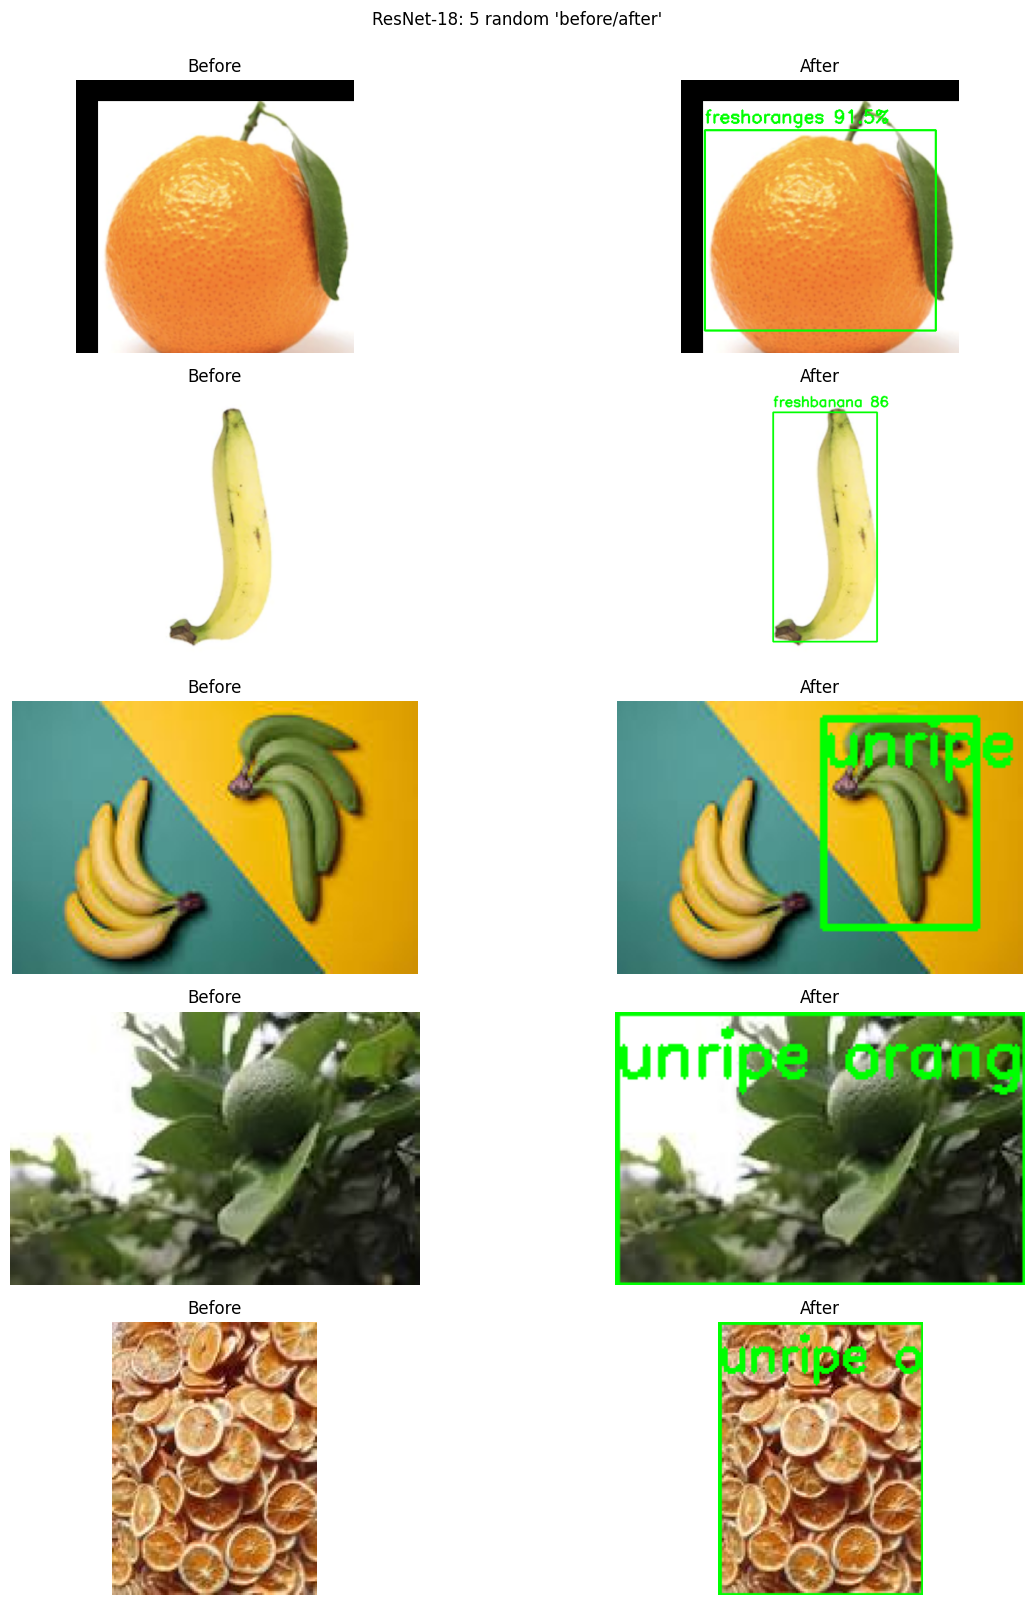

In [10]:
res_resnet  = train_eval_resnet18(epochs=10, base_lr=1e-2)


## YOlo v8 pretrain

In [19]:

import os, math, time, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
WORKERS = 2
WEIGHT_DECAY = 5e-4
BASE_LR = 7.14e-4 
MOMENTUM = 0.9    

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")





class TinyYOLOCls(nn.Module):
    def __init__(self, num_classes=9, in_ch=3):
        super().__init__()
        def conv(c_in, c_out, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, k, s, p, bias=False),
                nn.BatchNorm2d(c_out),
                nn.SiLU(inplace=True),
            )
        self.stem = conv(in_ch, 16, 3, 2, 1)     # 224 -> 112
        self.b1   = nn.Sequential(conv(16, 32, 3, 2, 1), conv(32, 32))      # 112 -> 56
        self.b2   = nn.Sequential(conv(32, 64, 3, 2, 1), conv(64, 64))      # 56  -> 28
        self.b3   = nn.Sequential(conv(64,128, 3, 2, 1), conv(128,128))     # 28  -> 14
        self.b4   = nn.Sequential(conv(128,256, 3, 2, 1), conv(256,256))    # 14  -> 7
        self.head = nn.Conv2d(256, num_classes, kernel_size=1, bias=True)   # "YOLO-style" 1x1 cls head
        # global average pooling happens in forward

        # Kaiming init for convs
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        x = self.stem(x)
        x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
        x = self.head(x)               # [B, C, H, W]
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)  # <- simplest & robust

        return x                       # logits



# --- eval_yolo_cls: use YOUR helpers only ---
def eval_yolo_cls(model, test_dir):
    """
    Evaluate on global dl_test/ds_test/classes.
    Uses your topk_from_logits to compute top-1/top-5.
    Returns: (top1, top5, cm, names_map, paths, y_true, y_pred)
    """
    model.eval()
    names = classes
    names_map = {i: n for i, n in enumerate(names)}

    y_true, y_pred = [], []

    # Pass 1: collect hard predictions for confusion matrix
    with torch.no_grad():
        for imgs, labels in dl_test:
            imgs = imgs.to(DEVICE, non_blocking=True)
            logits = model(imgs)
            idxs, _ = topk_from_logits(logits, k=5)     # (indices, probs)
            top1 = idxs[:, 0].cpu().numpy()
            y_pred.extend(top1.tolist())
            y_true.extend(labels.numpy().tolist())

    # Build confusion matrix (pure numpy; no extra helper)
    num_classes = len(names)
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    # Pass 2: compute mean top1/top5 using your topk_from_logits
    t1_list, t5_list = [], []
    with torch.no_grad():
        for imgs, labels in dl_test:
            imgs = imgs.to(DEVICE, non_blocking=True)
            logits = model(imgs)
            idxs, _ = topk_from_logits(logits, k=5)     # [B,5]
            top1_hits = (idxs[:, 0].cpu() == labels).float().mean().item()
            # top-5 hit: label is in any of the 5 predicted indices
            top5_hits = (idxs.cpu() == labels.view(-1, 1)).any(dim=1).float().mean().item()
            t1_list.append(top1_hits)
            t5_list.append(top5_hits)

    top1 = float(np.mean(t1_list))
    top5 = float(np.mean(t5_list))

    paths = [p for (p, _) in ds_test.samples]
    y_true_np = np.array(y_true); y_pred_np = np.array(y_pred)
    return top1, top5, cm, names_map, paths, y_true_np, y_pred_np
# --- train_eval_yolo: use YOUR topk_from_logits inside the quick validation ---
def train_eval_yolo(epochs=1, imgsz=IM_TRAIN):
    """
    Train TinyYOLOCls with your dataloaders, then eval + visuals (CM + per-class + before/after).
    Uses ONLY your helper functions for top-k and plots.
    """
    model = TinyYOLOCls(num_classes=num_classes).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=7.14e-4, weight_decay=5e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    print(f"[SimpleYOLO-Cls] Training on {len(ds_train)} images, {num_classes} classes, device={DEVICE}")
    for ep in range(1, epochs+1):
        model.train()
        running, n, t0 = 0.0, 0, time.time()
        for imgs, labels in dl_train:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)  # logits [B,C], labels [B]
            # (CE expects input [N,C] and target [N] — standard PyTorch API.) :contentReference[oaicite:0]{index=0}

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item() * imgs.size(0)
            n += imgs.size(0)

        sched.step()

        # Quick validation using YOUR topk_from_logits
        model.eval()
        t1_list, t5_list = [], []
        with torch.no_grad():
            for imgs, labels in dl_test:
                imgs = imgs.to(DEVICE, non_blocking=True)
                logits = model(imgs)
                idxs, _ = topk_from_logits(logits, k=5)  # (indices, probs) — torch.topk under the hood. :contentReference[oaicite:1]{index=1}
                top1_hits = (idxs[:, 0].cpu() == labels).float().mean().item()
                top5_hits = (idxs.cpu() == labels.view(-1, 1)).any(dim=1).float().mean().item()
                t1_list.append(top1_hits); t5_list.append(top5_hits)

        print(f"Epoch {ep}/{epochs} | loss {running/max(1,n):.4f} | "
              f"top1 {np.mean(t1_list)*100:.2f}% | top5 {np.mean(t5_list)*100:.2f}% | "
              f"lr {sched.get_last_lr()[0]:.6f} | time {time.time()-t0:.1f}s")

    # Final eval (uses your helpers + numpy CM)
    top1, top5, cm, names_map, paths, y_true, y_pred = eval_yolo_cls(model, TEST_DIR)
    print(f"\n[Final] Top-1: {top1*100:.2f}% | Top-5: {top5*100:.2f}%")

    # Plots using YOUR functions
    show_cm_and_bars(cm, "SimpleYOLO-Cls", classes)

    # Before/after grid (expects tf_test and PIL.Image)
    from PIL import Image
    def predict_fn(path):
        img = Image.open(path).convert("RGB")
        x = tf_test(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = model(x)
            idxs, probs = topk_from_logits(logits, k=5)
            top1_idx = int(idxs[0, 0].item())
            top1_p   = float(probs[0, 0].item())
        return classes[top1_idx], top1_p

    before_after_grid(paths, predict_fn, "SimpleYOLO-Cls: random 'before/after' with pseudo boxes", n=5)

    return {"top1": top1, "top5": top5}


[SimpleYOLO-Cls] Training on 16217 images, 9 classes, device=cuda
Epoch 1/1 | loss 1.2170 | top1 70.05% | top5 99.56% | lr 0.000000 | time 49.7s

[Final] Top-1: 70.05% | Top-5: 99.56%


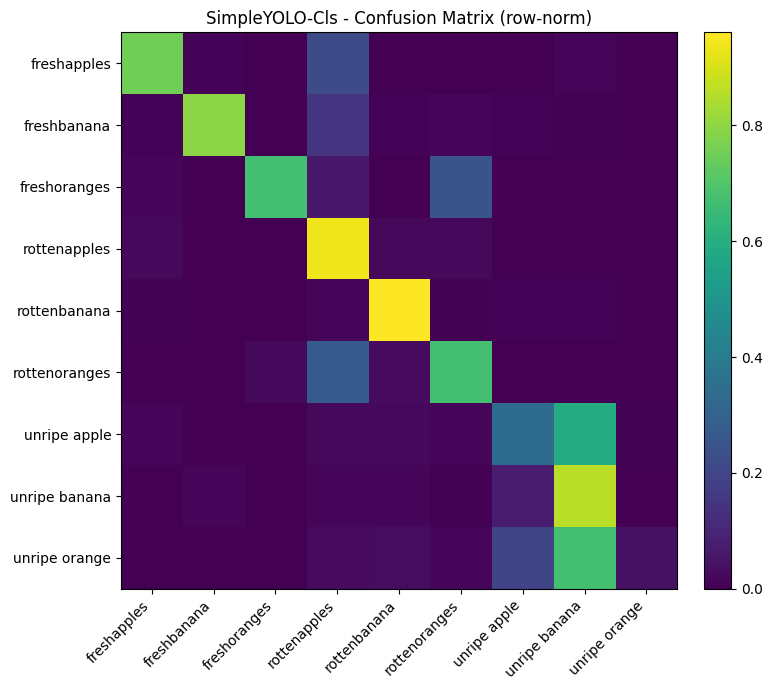

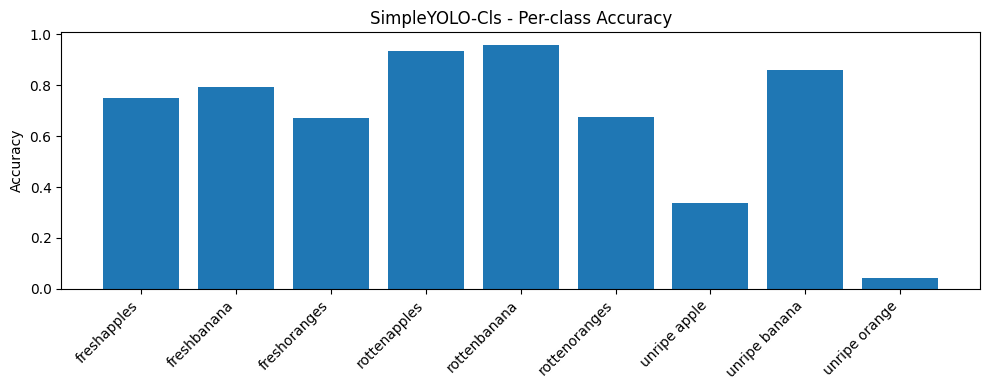

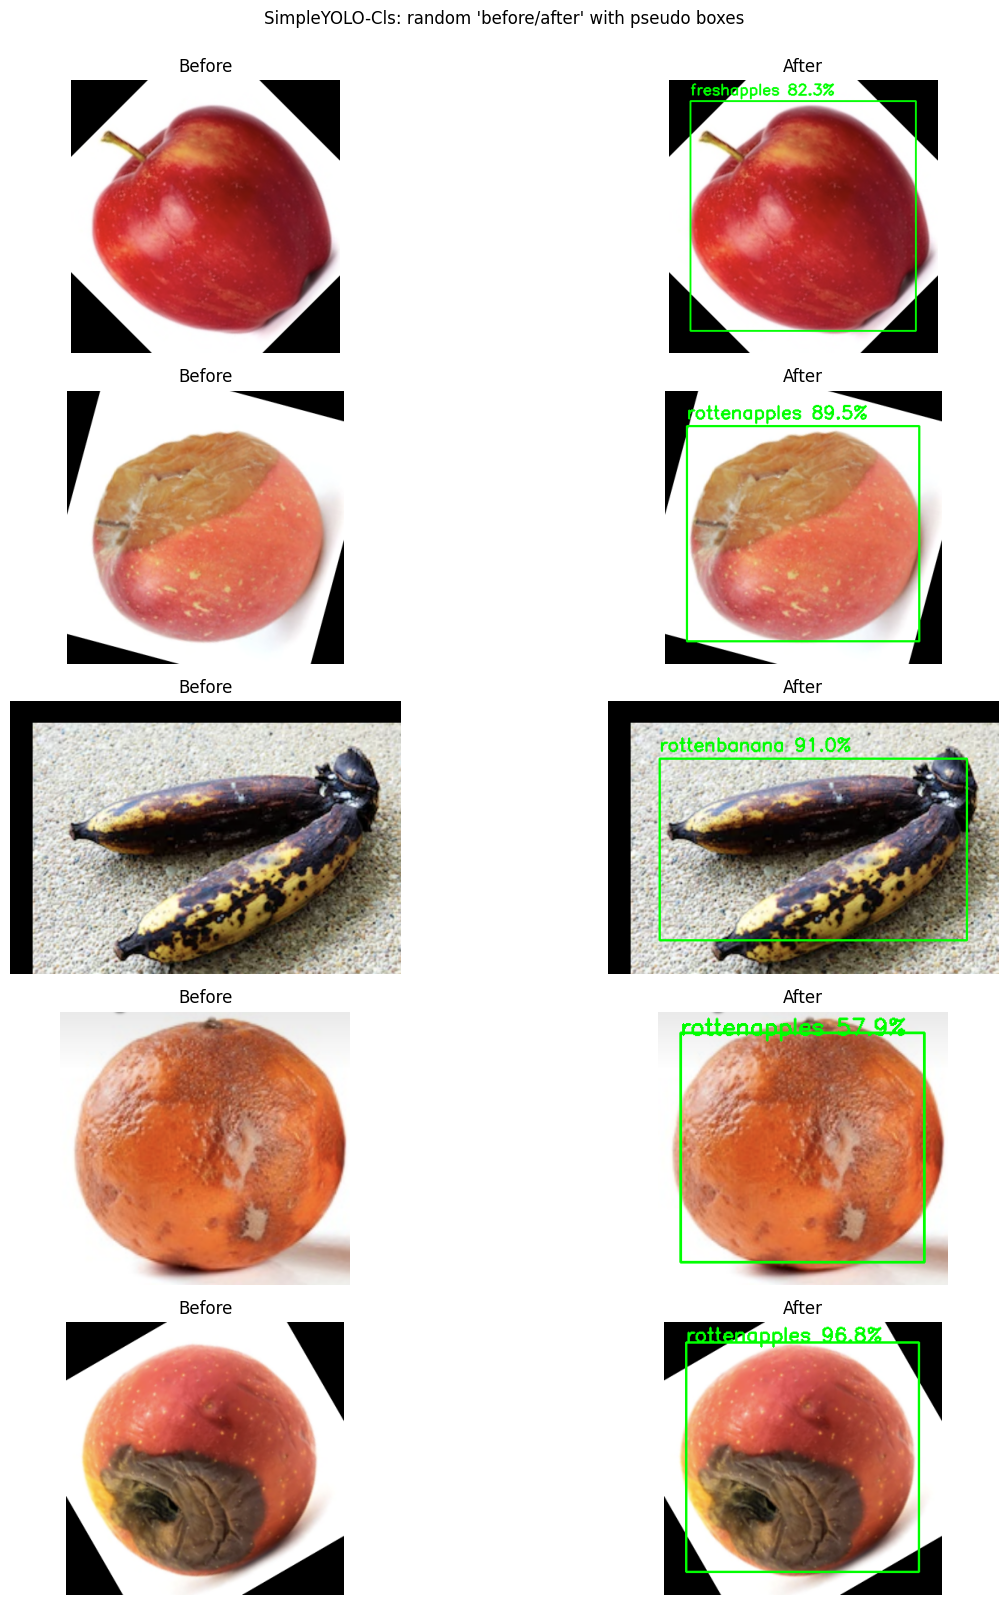

In [20]:
res_yolo = train_eval_yolo(epochs=1, imgsz=224)

# Result
in this we compare result of three model , the lenet is the most fundational and easy model architecture but it have a very limited result ( archive under < 80 % beside orther architecture archive more than 90 % , yolo is a easy choice but it is too larger and too 


In [21]:







print("\n=== SUMMARY (Top-1/Top-5) ===")
for k, r in [("LeNet", res_lenet), ("ResNet-18", res_resnet), ("YOLOv8n-cls", res_yolo)]:
    print(f"{k:>12s} -> Top-1 {r['top1']*100:5.2f}% | Top-5 {r['top5']*100:5.2f}%")





=== SUMMARY (Top-1/Top-5) ===
       LeNet -> Top-1 77.03% | Top-5 99.52%
   ResNet-18 -> Top-1 99.41% | Top-5 99.95%
 YOLOv8n-cls -> Top-1 70.05% | Top-5 99.56%
